# Use the joblib.dump function to save the trained model to the model.joblib file

In [1]:
import os
import deepchem as dc
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import joblib 

# 数据准备
data_file = 'compounds_ic50.csv'
raw_data = pd.read_csv(data_file)

# 确保IC50数据是数值类型
raw_data['IC50'] = pd.to_numeric(raw_data['IC50'], errors='coerce')

# 删除任何无效的数据
raw_data = raw_data.dropna(subset=['IC50'])

# 转换IC50为pIC50
raw_data['pIC50'] = -np.log10(raw_data['IC50'] * 1e-9)

# 更新数据文件
data_file_updated = 'compounds_pic50.csv'
raw_data.to_csv(data_file_updated, index=False)

# 特征化
featurizer = dc.feat.CircularFingerprint(size=1024)

# 数据加载和分割
loader = dc.data.CSVLoader(
    tasks=['pIC50'],
    feature_field='Smiles',
    featurizer=featurizer
)
dataset = loader.create_dataset(data_file_updated)

# Create and train model
sklearn_model = RandomForestRegressor()
model = dc.models.SklearnModel(sklearn_model)
model.fit(dataset)

# Ensure the model directory exists
model_dir = 'model_dir'
os.makedirs(model_dir, exist_ok=True)

# Save model
joblib.dump(sklearn_model, 'model.joblib')

# Load model
loaded_sklearn_model = joblib.load('model.joblib')
loaded_model = dc.models.SklearnModel(loaded_sklearn_model)

2023-10-21 22:52:38.238871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/zhoujunyu/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/Users/zhoujunyu/miniconda3/envs/myenv/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning 

# learning curve

Training R2: 0.95, RMSE: 0.27
Testing R2: 0.94, RMSE: 0.27


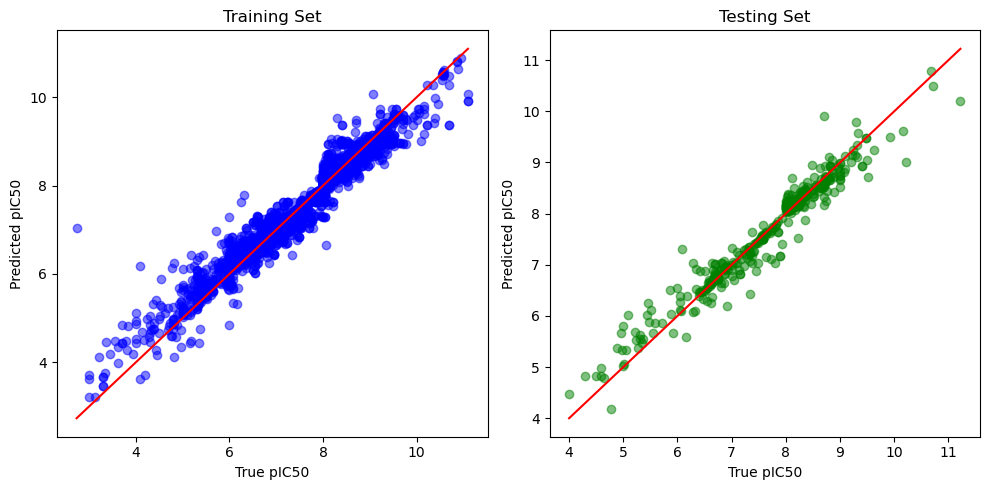

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import deepchem as dc
import numpy as np

# Assume you have split your data into training and testing sets
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

# Predict pIC50 values
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)

# Get true pIC50 values
train_true = train_dataset.y
test_true = test_dataset.y

# Calculate R2 and RMSE metrics for training and testing sets
train_r2 = r2_score(train_true, train_preds)
test_r2 = r2_score(test_true, test_preds)
train_rmse = np.sqrt(mean_squared_error(train_true, train_preds))
test_rmse = np.sqrt(mean_squared_error(test_true, test_preds))

print(f'Training R2: {train_r2:.2f}, RMSE: {train_rmse:.2f}')
print(f'Testing R2: {test_r2:.2f}, RMSE: {test_rmse:.2f}')

# Create scatter plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Specify color='blue' for training set
ax[0].scatter(train_true, train_preds, alpha=0.5, color='blue')
ax[0].plot([min(train_true), max(train_true)], [min(train_true), max(train_true)], color='red')  # Diagonal line
ax[0].set_title('Training Set')
ax[0].set_xlabel('True pIC50')
ax[0].set_ylabel('Predicted pIC50')

# Specify color='green' for testing set
ax[1].scatter(test_true, test_preds, alpha=0.5, color='green')
ax[1].plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], color='red')  # Diagonal line
ax[1].set_title('Testing Set')
ax[1].set_xlabel('True pIC50')
ax[1].set_ylabel('Predicted pIC50')

plt.tight_layout()
plt.savefig('Train_Test_pIC50.png', dpi=300, bbox_inches='tight')
plt.show()


# Output prediction results

In [3]:
import deepchem as dc
import pandas as pd
import joblib
import os

# Load the new data
new_data_file = 'bioactivity_data.csv'  # Replace with the path to your new data file
new_raw_data = pd.read_csv(new_data_file)

# Ensure the model directory exists
model_dir = 'model_dir'
os.makedirs(model_dir, exist_ok=True)

# Load the trained model
loaded_sklearn_model = joblib.load(os.path.join('model.joblib'))
loaded_model = dc.models.SklearnModel(loaded_sklearn_model)

# Featurize the new data
featurizer = dc.feat.CircularFingerprint(size=1024)
loader = dc.data.CSVLoader(
    tasks=[],  # The target column name, if the new data also contains actual pIC50 values
    feature_field='Smiles',
    featurizer=featurizer
)
new_dataset = loader.create_dataset(new_data_file)  # This assumes the new data file has a 'Smiles' column

# Make predictions
predicted_pIC50 = loaded_model.predict(new_dataset)

# Output the predictions
for i, pic50_value in enumerate(predicted_pIC50):
    print(f'Compound {i}: Predicted pIC50 = {pic50_value}')


Compound 0: Predicted pIC50 = 8.604176227918883
Compound 1: Predicted pIC50 = 8.2961954253007
Compound 2: Predicted pIC50 = 7.214144024529428
Compound 3: Predicted pIC50 = 8.615608588212803
Compound 4: Predicted pIC50 = 6.489555425813462
Compound 5: Predicted pIC50 = 7.374600347967162
Compound 6: Predicted pIC50 = 7.977798161322385
Compound 7: Predicted pIC50 = 8.359496737457272
Compound 8: Predicted pIC50 = 7.10195651866934
Compound 9: Predicted pIC50 = 7.177289826003911
Compound 10: Predicted pIC50 = 7.506667615270659
Compound 11: Predicted pIC50 = 7.656060439169158
Compound 12: Predicted pIC50 = 8.423259160537341
Compound 13: Predicted pIC50 = 8.36748749484713
Compound 14: Predicted pIC50 = 8.550962602453575
Compound 15: Predicted pIC50 = 7.0195049999763794
Compound 16: Predicted pIC50 = 7.7295105372717385
Compound 17: Predicted pIC50 = 6.369482532862448
Compound 18: Predicted pIC50 = 7.778450351392342
Compound 19: Predicted pIC50 = 8.76682487402471
Compound 20: Predicted pIC50 = 7.

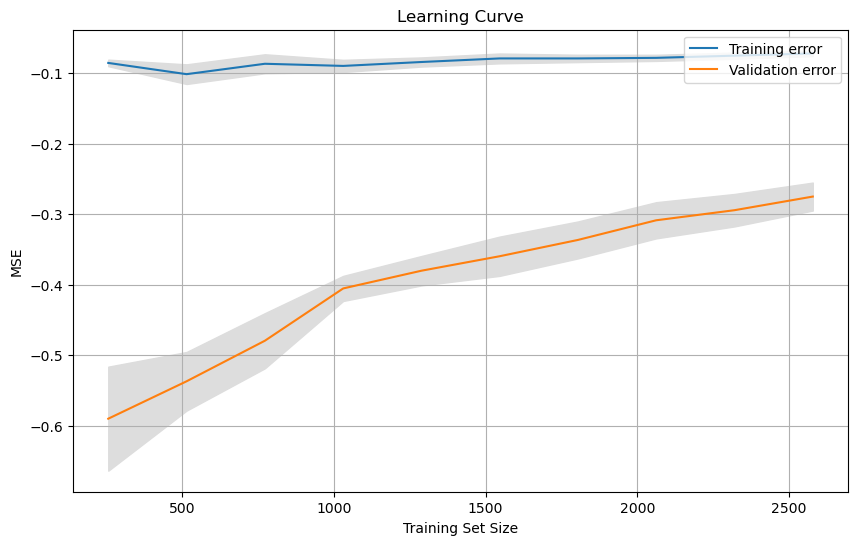

In [4]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Convert your DeepChem dataset to a format that can be used with scikit-learn
X_train = train_dataset.X
y_train = train_dataset.y

# Use the learning_curve function to generate learning curves for your model
train_sizes, train_scores, validation_scores = learning_curve(
    sklearn_model,  # Your sklearn model
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # Adjust as necessary
    cv=5,  # Adjust as necessary
    scoring='neg_mean_squared_error',  # Adjust as necessary
    n_jobs=-1  # Use all available cores
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training error')
plt.plot(train_sizes, validation_mean, label='Validation error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='#DDDDDD')
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='#DDDDDD')

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid()
plt.show()


#  data Cleaning

In [74]:
import numpy as np
import pandas as pd
import deepchem as dc

data_file = 'compounds_ic50.csv'
df = pd.read_csv(data_file)

featurizer = dc.feat.CircularFingerprint(size=1024)
features = df['Smiles'].apply(featurizer.featurize)
features = np.array(features.tolist())

invalid_rows = np.any(~np.isfinite(features), axis=1)

if np.any(invalid_rows):
    print(f"Removing {np.sum(invalid_rows)} rows with invalid values.")
    df = df[~invalid_rows]
    features = features[~invalid_rows]

df.to_csv('cleaned_data.csv', index=False)



# Smile input, CI50 output, used for training prediction

In [2]:
from chembl_webresource_client.new_client import new_client
import pandas as pd

# Read compounds.csv file
df = pd.read_csv('CHEMBL.csv')

# Initialize client
client = new_client

# Initialize an empty list to hold data
ic50_data = []

# Iterate through each ChEMBL ID and query the relevant IC50 data
for chembl_id in df['ChEMBL ID']:
    activities = client.activity.filter(molecule_chembl_id=chembl_id, standard_type="IC50").only(
        'standard_value', 'standard_units'
    )
    # Obtain biological activity IC50 value (average multiple)
    if len(activities) > 0:
        avg_ic50 = sum([float(activity['standard_value']) for activity in activities if activity['standard_value'] is not None]) / len(activities)
        ic50_data.append({'ChEMBL ID': chembl_id, 'Average IC50 (nM)': avg_ic50})

# Save the results to a new CSV file
ic50_df = pd.DataFrame(ic50_data)
ic50_df.to_csv('ic50_values.csv', index=False)


KeyboardInterrupt: 